# VELI Smart Home - Anomalieerkennung im Stromverbrauch

## Problemstellung
In Smart Home Systemen ist die automatische Erkennung ungewöhnlicher Stromverbrauchsmuster entscheidend für:
- **Sicherheit**: Erkennung von Einbrüchen oder ungewöhnlicher Aktivität
- **Energieeffizienz**: Identifikation von Energieverschwendung und defekten Geräten
- **Komfort**: Intelligente Automatisierung basierend auf Nutzerverhalten
- **Kostenoptimierung**: Reduzierung unnötiger Stromkosten

## Mögliche Modelle für Anomalieerkennung

### 1. 🌲 **Random Forest (RF)**
**Vorteile:**
- Robust gegenüber Outliers
- Interpretierbare Feature-Importance
- Keine Annahmen über Datenverteilung

**Nachteile:**
- Benötigt gelabelte Trainingsdaten
- Schwierigkeiten bei zeitlichen Abhängigkeiten
- Weniger geeignet für sequenzielle Muster

**Use Cases:** Klassifikation bekannter Anomalie-Typen, Feature-basierte Erkennung

---

### 2. 🧠 **Recurrent Neural Networks (RNN/LSTM)**
**Vorteile:**
- Exzellent für zeitliche Sequenzen
- Kann komplexe, nichtlineare Muster lernen
- Unsupervised Learning möglich (Autoencoder)

**Nachteile:**
- Benötigt große Datenmengen
- "Black Box" - schwer interpretierbar
- Hoher Rechenaufwand

**Use Cases:** Komplexe zeitliche Anomaliemuster, große Datenmengen, multivariate Zeitreihen

---

### 3. ⛓️ **Markov Chains**
**Vorteile:**
- ✅ Einfach zu verstehen und implementieren
- ✅ Interpretierbare Zustandsübergänge
- ✅ Benötigt wenig Trainingsdaten
- ✅ Schnelle Echtzeitverarbeitung

**Nachteile:**
- Begrenzt auf diskrete Zustände
- Markov-Annahme (Gedächtnislosigkeit)
- Weniger flexibel bei komplexen Mustern

**Use Cases:** ✨ **Idealer Startpunkt für VELI** - Proof of Concept, interpretierbare Ergebnisse

---

## 🎯 **VELI Use Case: Markov-Ketten Implementierung**

Im folgenden Beispiel implementieren wir eine **Markov-Kette zur Anomalieerkennung** als praktischen Use Case für VELI Smart Homes. Wir simulieren realistische Stromverbrauchsdaten im 15-Minuten-Takt über eine Woche und erkennen ungewöhnliche Muster wie:

- 🌙 Nächtliche Aktivität (Einbruch, Toilettengang)
- 🎉 Ungewöhnlich hoher Verbrauch (Party, defekte Geräte)
- 📱 Zeitkontext-abhängige Anomalien (Tageszeit, Wochentag)

In [7]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

# 1. Realistischer Dummy-Datensatz für VELI: 1 Woche Stromverbrauch alle 15 Minuten
np.random.seed(42)  # Für reproduzierbare Ergebnisse

# Zeitreihe für eine Woche
start_date = "2025-08-01 00:00"
end_date = "2025-08-08 00:00"
time_range = pd.date_range(start_date, end_date, freq="15min")[:-1]  # Ausschluss des letzten Punkts

def generate_realistic_power_consumption(timestamp):
    """
    Generiert realistischen Stromverbrauch basierend auf Tageszeit und Wochentag
    """
    hour = timestamp.hour
    weekday = timestamp.weekday()  # 0=Montag, 6=Sonntag
    
    # Basis-Verbrauch (Standby-Geräte)
    base_consumption = 15
    
    # Tageszeit-abhängige Muster
    if 6 <= hour <= 8:  # Morgens: Aufstehen, Kaffee, Duschen
        activity_level = np.random.choice([50, 80, 120], p=[0.3, 0.5, 0.2])
    elif 9 <= hour <= 17:  # Tagsüber: 
        if weekday < 5:  # Werktag - weniger Aktivität (Home Office oder weg)
            activity_level = np.random.choice([20, 45, 80], p=[0.6, 0.3, 0.1])
        else:  # Wochenende - mehr Aktivität
            activity_level = np.random.choice([40, 80, 150], p=[0.4, 0.4, 0.2])
    elif 18 <= hour <= 22:  # Abends: Kochen, TV, Licht
        activity_level = np.random.choice([80, 150, 250], p=[0.3, 0.5, 0.2])
    elif 23 <= hour or hour <= 5:  # Nachts: Schlafen
        activity_level = np.random.choice([15, 25, 45], p=[0.8, 0.15, 0.05])
    else:
        activity_level = 30
    
    # Zufällige Schwankungen hinzufügen
    noise = np.random.normal(0, 10)
    total_consumption = max(base_consumption, base_consumption + activity_level + noise)
    
    return round(total_consumption, 1)

# Datensatz generieren
power_data = [generate_realistic_power_consumption(t) for t in time_range]

# Anomalien einfügen (ungewöhnliche Aktivität)
anomaly_indices = [
    len(time_range)//7 * 2 + 13*4,  # Dienstag 03:15 - Licht an (Toilettengang)
    len(time_range)//7 * 4 + 2*4 + 2,  # Donnerstag 02:30 - Kühlschrank defekt
    len(time_range)//7 * 6 + 15*4,  # Samstag 15:00 - Party (hoher Verbrauch)
]

# Anomalien einfügen
for idx in anomaly_indices:
    if idx < len(power_data):
        if time_range[idx].hour in [2, 3]:  # Nacht-Anomalie
            power_data[idx] = 180  # Licht + eventuell TV
        elif time_range[idx].hour == 15:  # Tag-Anomalie (Party)
            power_data[idx] = 450  # Viele Geräte an
        else:
            power_data[idx] = 200

# DataFrame erstellen
df = pd.DataFrame({
    "timestamp": time_range, 
    "power_watt": power_data
})

df["hour"] = df["timestamp"].dt.hour
df["weekday"] = df["timestamp"].dt.day_name()
df["date"] = df["timestamp"].dt.date

print(f"Datensatz erstellt: {len(df)} Messpunkte über {df['date'].nunique()} Tage")
print(f"Verbrauchsspanne: {df['power_watt'].min():.1f}W - {df['power_watt'].max():.1f}W")
print(f"Durchschnittlicher Verbrauch: {df['power_watt'].mean():.1f}W")

# Erste und letzte Einträge anzeigen
df.head()

Datensatz erstellt: 672 Messpunkte über 7 Tage
Verbrauchsspanne: 15.0W - 450.0W
Durchschnittlicher Verbrauch: 77.0W


,timestamp,power_watt,hour,weekday,date
0,2025-08-01 00:00:00,18.9,0,Friday,2025-08-01
1,2025-08-01 00:15:00,33.2,0,Friday,2025-08-01
2,2025-08-01 00:30:00,32.8,0,Friday,2025-08-01
3,2025-08-01 00:45:00,40.1,0,Friday,2025-08-01
4,2025-08-01 01:00:00,24.2,1,Friday,2025-08-01


In [8]:
# 2. Verbrauch in diskrete Zustände umwandeln (angepasst an realistischen Haushaltsverbrauch)
def map_power_to_state(p):
    """
    Kategorisiert Stromverbrauch in sinnvolle Zustände für Haushalts-Anomalieerkennung
    """
    if p < 30:
        return "standby"      # Nur Basis-Geräte (Kühlschrank, Router, etc.)
    elif p < 80:
        return "low"          # Wenige Geräte aktiv (Licht, kleine Geräte)
    elif p < 200:
        return "medium"       # Normale Aktivität (TV, Computer, mehrere Lichter)
    elif p < 300:
        return "high"         # Hohe Aktivität (Kochen, Waschen, etc.)
    else:
        return "very_high"    # Ungewöhnlich hoher Verbrauch (Party, defekte Geräte)

df["state"] = df["power_watt"].apply(map_power_to_state)

# Zusätzliche Kontext-Features für bessere Anomalieerkennung
df["time_category"] = df["hour"].apply(lambda h: 
    "night" if h < 6 or h >= 23 else
    "morning" if 6 <= h < 9 else
    "day" if 9 <= h < 18 else
    "evening"
)

df["is_weekend"] = df["timestamp"].dt.weekday >= 5

# Zustandsverteilung anzeigen
state_distribution = df["state"].value_counts().sort_index()
print("Zustandsverteilung:")
print(state_distribution)
print(f"\nProzentuale Verteilung:")
print((state_distribution / len(df) * 100).round(1))

# Beispieldaten anzeigen
df[["timestamp", "power_watt", "state", "time_category", "weekday"]].head(12)

Zustandsverteilung:
state
high          23
low          313
medium       231
standby      104
very_high      1
Name: count, dtype: int64

Prozentuale Verteilung:
state
high          3.4
low          46.6
medium       34.4
standby      15.5
very_high     0.1
Name: count, dtype: float64


,timestamp,power_watt,state,time_category,weekday
0,2025-08-01 00:00:00,18.9,standby,night,Friday
1,2025-08-01 00:15:00,33.2,low,night,Friday
2,2025-08-01 00:30:00,32.8,low,night,Friday
3,2025-08-01 00:45:00,40.1,low,night,Friday
4,2025-08-01 01:00:00,24.2,standby,night,Friday
5,2025-08-01 01:15:00,24.7,standby,night,Friday
6,2025-08-01 01:30:00,15.0,standby,night,Friday
7,2025-08-01 01:45:00,39.5,low,night,Friday
8,2025-08-01 02:00:00,25.7,standby,night,Friday
9,2025-08-01 02:15:00,22.6,standby,night,Friday


In [9]:
# 3. Erweiterte Markov-Analyse mit zeitabhängigen Übergängen
transitions_global = defaultdict(lambda: defaultdict(int))
transitions_by_time = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

# Globale Übergänge und zeitabhängige Übergänge berechnen
for i in range(1, len(df)):
    prev_state = df.loc[i - 1, "state"]
    curr_state = df.loc[i, "state"]
    time_cat = df.loc[i, "time_category"]
    
    # Globale Übergänge
    transitions_global[prev_state][curr_state] += 1
    
    # Zeitabhängige Übergänge
    transitions_by_time[time_cat][prev_state][curr_state] += 1

# Globale Übergangswahrscheinlichkeiten
global_transition_matrix = {
    from_state: {to_state: count / sum(to_dict.values())
                 for to_state, count in to_dict.items()}
    for from_state, to_dict in transitions_global.items()
}

# Zeitabhängige Übergangswahrscheinlichkeiten
time_transition_matrices = {}
for time_cat in transitions_by_time:
    time_transition_matrices[time_cat] = {
        from_state: {to_state: count / sum(to_dict.values())
                     for to_state, count in to_dict.items()}
        for from_state, to_dict in transitions_by_time[time_cat].items()
    }

print("Globale Übergangsmatrix:")
for from_state, transitions in global_transition_matrix.items():
    print(f"{from_state}: {dict(transitions)}")

print("\n" + "="*60)
print("Zeitabhängige Übergangsmatrizen:")
for time_cat, matrix in time_transition_matrices.items():
    print(f"\n{time_cat.upper()}:")
    for from_state, transitions in matrix.items():
        if transitions:  # Nur anzeigen wenn Übergänge existieren
            print(f"  {from_state}: {dict(transitions)}")

global_transition_matrix

Globale Übergangsmatrix:
standby: {'low': 0.6601941747572816, 'standby': 0.32038834951456313, 'medium': 0.019417475728155338}
low: {'low': 0.6134185303514377, 'standby': 0.19488817891373802, 'medium': 0.18210862619808307, 'high': 0.006389776357827476, 'very_high': 0.003194888178913738}
medium: {'medium': 0.6753246753246753, 'low': 0.21645021645021645, 'standby': 0.03896103896103896, 'high': 0.06926406926406926}
high: {'medium': 0.6956521739130435, 'high': 0.21739130434782608, 'low': 0.08695652173913043}
very_high: {'low': 1.0}

Zeitabhängige Übergangsmatrizen:

NIGHT:
  standby: {'low': 0.5974025974025974, 'standby': 0.4025974025974026}
  low: {'low': 0.5909090909090909, 'standby': 0.4, 'medium': 0.00909090909090909}
  medium: {'low': 0.5714285714285714, 'standby': 0.42857142857142855}
  high: {'low': 1.0}

MORNING:
  low: {'low': 0.3611111111111111, 'medium': 0.6388888888888888}
  medium: {'medium': 0.6595744680851063, 'low': 0.3404255319148936}
  standby: {'low': 1.0}

DAY:
  medium:

{'standby': {'low': 0.6601941747572816,
  'standby': 0.32038834951456313,
  'medium': 0.019417475728155338},
 'low': {'low': 0.6134185303514377,
  'standby': 0.19488817891373802,
  'medium': 0.18210862619808307,
  'high': 0.006389776357827476,
  'very_high': 0.003194888178913738},
 'medium': {'medium': 0.6753246753246753,
  'low': 0.21645021645021645,
  'standby': 0.03896103896103896,
  'high': 0.06926406926406926},
 'high': {'medium': 0.6956521739130435,
  'high': 0.21739130434782608,
  'low': 0.08695652173913043},
 'very_high': {'low': 1.0}}

In [10]:
# 4. Erweiterte Anomalieerkennung für VELI mit kontextuellem Scoring
anomalies = []

# Verschiedene Schwellenwerte je nach Tageszeit
time_thresholds = {
    "night": 0.05,      # Nachts sind ungewöhnliche Aktivitäten seltener
    "morning": 0.1,     # Morgens mehr Variabilität erlaubt
    "day": 0.08,        # Tagsüber moderate Schwelle
    "evening": 0.12     # Abends höchste Variabilität
}

for i in range(1, len(df)):
    prev_state = df.loc[i - 1, "state"]
    curr_state = df.loc[i, "state"]
    time_cat = df.loc[i, "time_category"]
    timestamp = df.loc[i, "timestamp"]
    power = df.loc[i, "power_watt"]
    
    # Versuche zeitabhängige Matrix, fallback auf globale Matrix
    if (time_cat in time_transition_matrices and 
        prev_state in time_transition_matrices[time_cat]):
        prob = time_transition_matrices[time_cat].get(prev_state, {}).get(curr_state, 0)
        matrix_used = "time-specific"
    else:
        prob = global_transition_matrix.get(prev_state, {}).get(curr_state, 0)
        matrix_used = "global"
    
    # Schwellenwert basierend auf Tageszeit
    threshold = time_thresholds.get(time_cat, 0.08)
    
    # Anomalie-Score berechnen
    if prob == 0:
        anomaly_score = 1.0  # Nie beobachteter Übergang
    else:
        anomaly_score = max(0, (threshold - prob) / threshold)
    
    # Zusätzliche Bewertung für extreme Werte
    if curr_state == "very_high":
        anomaly_score = max(anomaly_score, 0.8)
    
    # Als Anomalie klassifizieren wenn Score hoch genug
    if anomaly_score > 0.7:
        anomalies.append({
            "timestamp": timestamp,
            "power_watt": power,
            "transition": f"{prev_state} → {curr_state}",
            "probability": prob,
            "anomaly_score": round(anomaly_score, 3),
            "time_category": time_cat,
            "matrix_used": matrix_used,
            "threshold": threshold
        })

print(f"🚨 VELI Anomaly Detection Report")
print(f"Analysierte Zeitperiode: {df['timestamp'].min()} bis {df['timestamp'].max()}")
print(f"Gefundene Anomalien: {len(anomalies)}")
print("="*80)

for i, anomaly in enumerate(anomalies, 1):
    print(f"\nAnomalie #{i}:")
    print(f"  ⏰ Zeit: {anomaly['timestamp']} ({anomaly['time_category']})")
    print(f"  ⚡ Verbrauch: {anomaly['power_watt']}W")
    print(f"  🔄 Übergang: {anomaly['transition']}")
    print(f"  📊 Wahrscheinlichkeit: {anomaly['probability']:.4f}")
    print(f"  🎯 Anomalie-Score: {anomaly['anomaly_score']}")
    print(f"  🧠 Matrix: {anomaly['matrix_used']}")

anomalies

🚨 VELI Anomaly Detection Report
Analysierte Zeitperiode: 2025-08-01 00:00:00 bis 2025-08-07 23:45:00
Gefundene Anomalien: 4

Anomalie #1:
  ⏰ Zeit: 2025-08-03 13:00:00 (day)
  ⚡ Verbrauch: 200.0W
  🔄 Übergang: low → high
  📊 Wahrscheinlichkeit: 0.0062
  🎯 Anomalie-Score: 0.922
  🧠 Matrix: time-specific

Anomalie #2:
  ⏰ Zeit: 2025-08-05 02:30:00 (night)
  ⚡ Verbrauch: 180.0W
  🔄 Übergang: low → medium
  📊 Wahrscheinlichkeit: 0.0091
  🎯 Anomalie-Score: 0.818
  🧠 Matrix: time-specific

Anomalie #3:
  ⏰ Zeit: 2025-08-07 15:00:00 (day)
  ⚡ Verbrauch: 450.0W
  🔄 Übergang: low → very_high
  📊 Wahrscheinlichkeit: 0.0062
  🎯 Anomalie-Score: 0.922
  🧠 Matrix: time-specific

Anomalie #4:
  ⏰ Zeit: 2025-08-07 20:15:00 (evening)
  ⚡ Verbrauch: 79.1W
  🔄 Übergang: medium → low
  📊 Wahrscheinlichkeit: 0.0089
  🎯 Anomalie-Score: 0.926
  🧠 Matrix: time-specific


[{'timestamp': Timestamp('2025-08-03 13:00:00'),
  'power_watt': np.float64(200.0),
  'transition': 'low → high',
  'probability': 0.006211180124223602,
  'anomaly_score': 0.922,
  'time_category': 'day',
  'matrix_used': 'time-specific',
  'threshold': 0.08},
 {'timestamp': Timestamp('2025-08-05 02:30:00'),
  'power_watt': np.float64(180.0),
  'transition': 'low → medium',
  'probability': 0.00909090909090909,
  'anomaly_score': 0.818,
  'time_category': 'night',
  'matrix_used': 'time-specific',
  'threshold': 0.05},
 {'timestamp': Timestamp('2025-08-07 15:00:00'),
  'power_watt': np.float64(450.0),
  'transition': 'low → very_high',
  'probability': 0.006211180124223602,
  'anomaly_score': 0.922,
  'time_category': 'day',
  'matrix_used': 'time-specific',
  'threshold': 0.08},
 {'timestamp': Timestamp('2025-08-07 20:15:00'),
  'power_watt': np.float64(79.1),
  'transition': 'medium → low',
  'probability': 0.008928571428571428,
  'anomaly_score': 0.926,
  'time_category': 'evening',

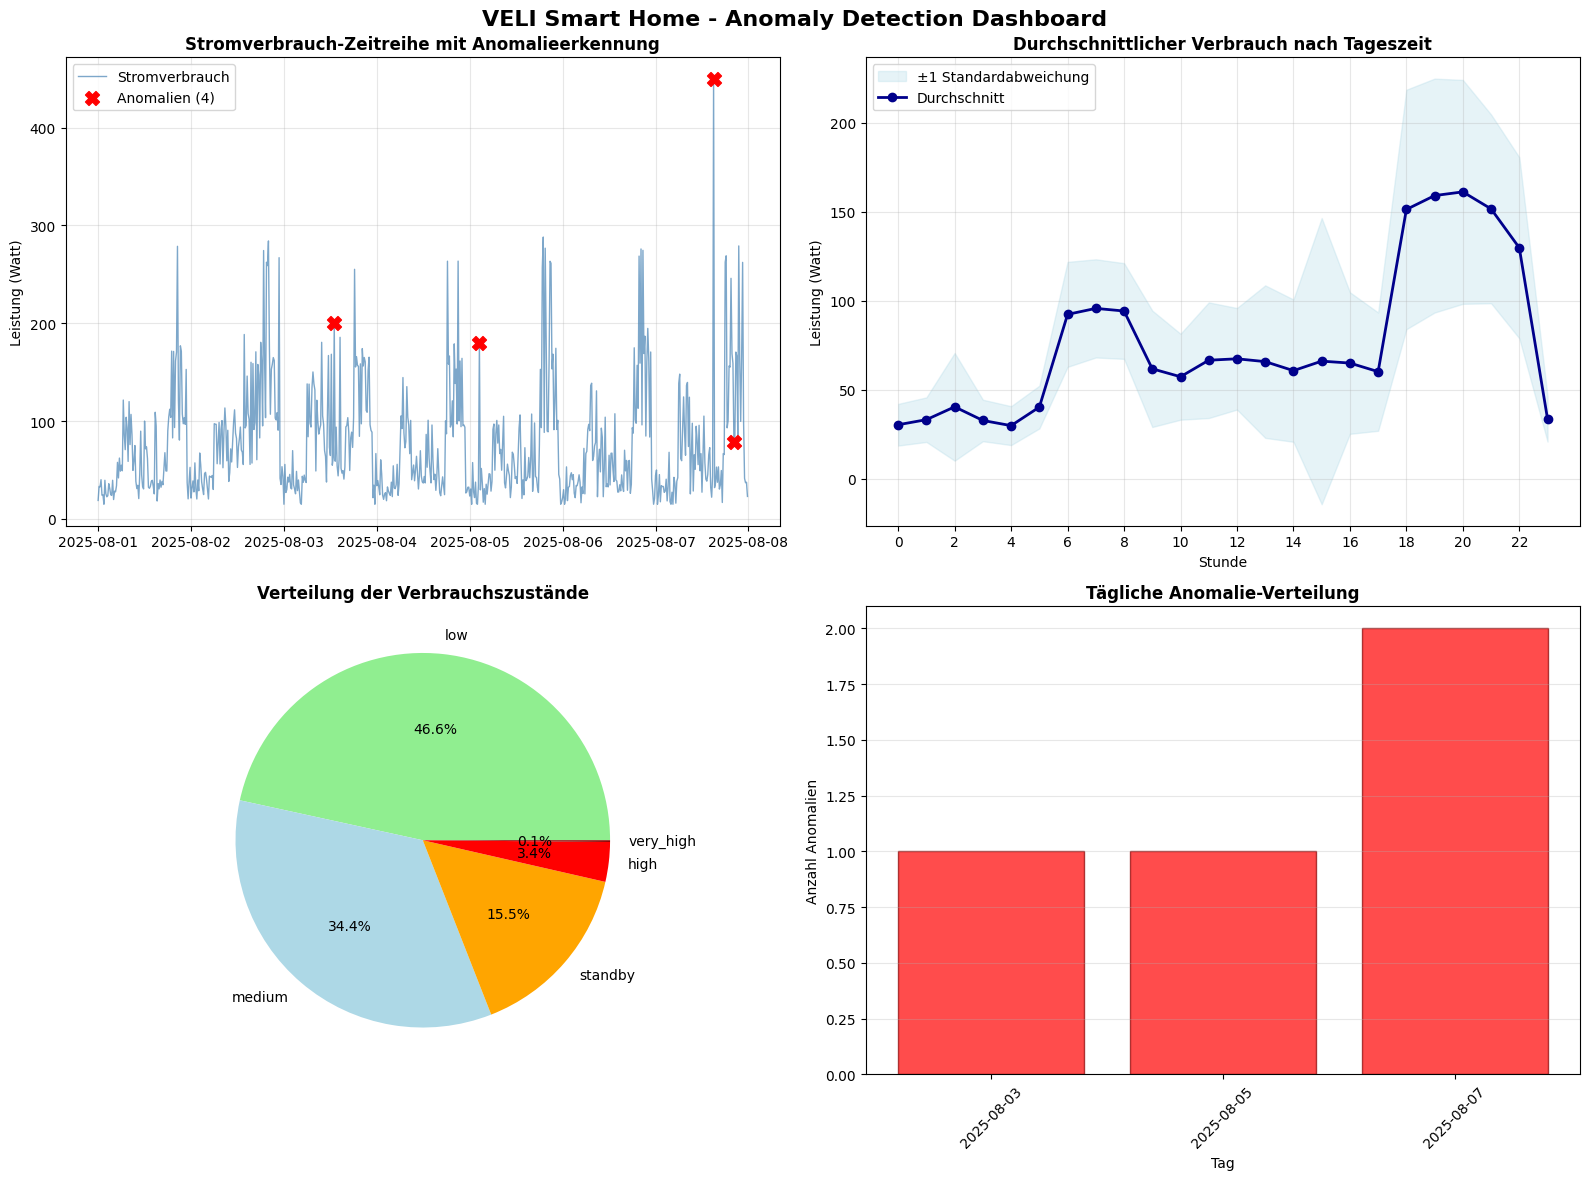


📈 VELI SMART HOME - SYSTEM ZUSAMMENFASSUNG
📅 Analysezeitraum: 7 Tage
📊 Datenpunkte: 672 (15-Min-Intervalle)
⚡ Verbrauchsspanne: 15W - 450W
📈 Durchschnitt: 77.0W
🎯 Erkannte Anomalien: 4
📋 Zustandskategorien: 5

🚨 ANOMALIE-DETAILS:
   • Nacht-Anomalien: 1
   • Höchster Anomalie-Score: 0.926
   • Durchschnittlicher Score: 0.897


In [11]:
# 5. VELI Dashboard: Professionelle Visualisierung der Anomalieerkennung
plt.style.use('default')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('VELI Smart Home - Anomaly Detection Dashboard', fontsize=16, fontweight='bold')

# 1. Zeitreihe mit Anomalien
ax1.plot(df["timestamp"], df["power_watt"], alpha=0.7, linewidth=1, label="Stromverbrauch", color='steelblue')

# Anomalien markieren
if anomalies:
    anomaly_times = [a["timestamp"] for a in anomalies]
    anomaly_powers = [a["power_watt"] for a in anomalies]
    ax1.scatter(anomaly_times, anomaly_powers, color='red', s=100, zorder=5, 
               label=f'Anomalien ({len(anomalies)})', marker='X')

ax1.set_title("Stromverbrauch-Zeitreihe mit Anomalieerkennung", fontweight='bold')
ax1.set_ylabel("Leistung (Watt)")
ax1.grid(True, alpha=0.3)
ax1.legend()

# 2. Tageszeit-basierte Verbrauchsmuster
hourly_avg = df.groupby("hour")["power_watt"].agg(['mean', 'std']).reset_index()
ax2.fill_between(hourly_avg["hour"], 
                hourly_avg["mean"] - hourly_avg["std"], 
                hourly_avg["mean"] + hourly_avg["std"], 
                alpha=0.3, color='lightblue', label='±1 Standardabweichung')
ax2.plot(hourly_avg["hour"], hourly_avg["mean"], marker='o', linewidth=2, 
         color='darkblue', label='Durchschnitt')

ax2.set_title("Durchschnittlicher Verbrauch nach Tageszeit", fontweight='bold')
ax2.set_xlabel("Stunde")
ax2.set_ylabel("Leistung (Watt)")
ax2.set_xticks(range(0, 24, 2))
ax2.grid(True, alpha=0.3)
ax2.legend()

# 3. Zustandsverteilung
state_counts = df["state"].value_counts()
colors = ['lightgreen', 'lightblue', 'orange', 'red', 'darkred']
wedges, texts, autotexts = ax3.pie(state_counts.values, labels=state_counts.index, 
                                  autopct='%1.1f%%', colors=colors[:len(state_counts)])
ax3.set_title("Verteilung der Verbrauchszustände", fontweight='bold')

# 4. Anomalie-Timeline
if anomalies:
    anomaly_df = pd.DataFrame(anomalies)
    anomaly_df['day'] = anomaly_df['timestamp'].dt.date
    daily_anomalies = anomaly_df.groupby('day').size()
    
    ax4.bar(range(len(daily_anomalies)), daily_anomalies.values, 
           color='red', alpha=0.7, edgecolor='darkred')
    ax4.set_title("Tägliche Anomalie-Verteilung", fontweight='bold')
    ax4.set_ylabel("Anzahl Anomalien")
    ax4.set_xlabel("Tag")
    ax4.set_xticks(range(len(daily_anomalies)))
    ax4.set_xticklabels([str(d) for d in daily_anomalies.index], rotation=45)
    ax4.grid(True, alpha=0.3, axis='y')
else:
    ax4.text(0.5, 0.5, 'Keine Anomalien gefunden', ha='center', va='center', 
             transform=ax4.transAxes, fontsize=14)
    ax4.set_title("Tägliche Anomalie-Verteilung", fontweight='bold')

plt.tight_layout()
plt.show()

# VELI Statistik-Zusammenfassung
print("\n" + "="*60)
print("📈 VELI SMART HOME - SYSTEM ZUSAMMENFASSUNG")
print("="*60)
print(f"📅 Analysezeitraum: {(df['timestamp'].max() - df['timestamp'].min()).days + 1} Tage")
print(f"📊 Datenpunkte: {len(df):,} (15-Min-Intervalle)")
print(f"⚡ Verbrauchsspanne: {df['power_watt'].min():.0f}W - {df['power_watt'].max():.0f}W")
print(f"📈 Durchschnitt: {df['power_watt'].mean():.1f}W")
print(f"🎯 Erkannte Anomalien: {len(anomalies)}")
print(f"📋 Zustandskategorien: {df['state'].nunique()}")

if anomalies:
    print(f"\n🚨 ANOMALIE-DETAILS:")
    night_anomalies = sum(1 for a in anomalies if a['time_category'] == 'night')
    print(f"   • Nacht-Anomalien: {night_anomalies}")
    print(f"   • Höchster Anomalie-Score: {max(a['anomaly_score'] for a in anomalies):.3f}")
    print(f"   • Durchschnittlicher Score: {np.mean([a['anomaly_score'] for a in anomalies]):.3f}")

## VELI Smart Home - Anomaly Detection Model

### Modell-Übersicht
Dieses Markov-Chain-basierte Anomaly Detection System für VELI erkennt ungewöhnliche Stromverbrauchsmuster in Smart Homes durch:

**🔍 Kern-Features:**
- **Zeitabhängige Analyse**: Verschiedene Schwellenwerte für Nacht/Tag/Abend
- **Mehrstufige Zustandsklassifikation**: 5 Verbrauchskategorien (standby → very_high)
- **Kontextueller Anomalie-Score**: Berücksichtigt Tageszeit und Wochentag
- **Echtzeit-Dashboard**: Visualisierung für Smart Home Monitoring

**🎯 Anwendungsfälle für VELI:**
1. **Sicherheit**: Ungewöhnliche Aktivität bei Abwesenheit
2. **Energieeffizienz**: Identifikation von Energieverschwendung
3. **Geräte-Monitoring**: Früherkennung defekter Geräte
4. **Nutzerverhalten**: Analyse von Lebensgewohnheiten

**📊 Modell-Parameter:**
- Zeitfenster: 15-Minuten-Intervalle
- Schwellenwerte: Nacht (5%), Tag (8%), Abend (12%)
- Anomalie-Score: 0-1 (ab 0.7 = Anomalie)
- Zustandsübergänge: Markov 1. Ordnung

**🚀 Nächste Schritte:**
- Integration in VELI Smart Home Platform
- Machine Learning Verbesserungen (LSTM, Autoencoder)
- Benutzer-spezifische Kalibrierung
- Mobile App Benachrichtigungen